In [1]:
import project.train_logger as train_logger
import matplotlib.pyplot as plt

%load_ext autoreload

In [2]:
logger = train_logger.TrainingLogger("../odnlggds.db")

Connecting to existing database at ../odnlggds.db


In [3]:
for id in logger.get_experiment_ids():
    print(id, logger.get_experiment_name(id))

1 Real+Gen
2 Real+Our
3 Real


In [4]:
for exp in logger.get_experiment_ids():
    results = logger.get_results(exp)
    print(f"Experiment {exp}: {logger.get_experiment_name(exp)}")
    print(f"run_id | epoch| train_loss| train_acc| test_loss| test_acc")
    for run_id, epoch, train_loss, train_acc, test_loss, test_acc in results:
        print(f"{run_id:7d}| {epoch:5d}| {train_loss:10.2f}| {train_acc:9.2f}| {test_loss:9.2f}| {test_acc:8.2f}")

Experiment 1: Real+Gen
run_id | epoch| train_loss| train_acc| test_loss| test_acc
      1|     0|       1.65|      0.40|      1.38|     0.52
      1|     0|       1.64|      0.40|      1.48|     0.49
      1|     1|       1.28|      0.54|      1.12|     0.61
      1|     1|       1.28|      0.54|      1.09|     0.62
      1|     2|       1.11|      0.61|      1.03|     0.65
      1|     2|       1.10|      0.61|      1.05|     0.65
      1|     3|       1.00|      0.65|      0.97|     0.67
      1|     3|       0.99|      0.65|      1.01|     0.66
      1|     4|       0.91|      0.68|      0.83|     0.71
      1|     4|       0.91|      0.68|      1.02|     0.67
      1|     5|       0.85|      0.70|      0.84|     0.71
      1|     5|       0.85|      0.70|      0.85|     0.71
      1|     6|       0.80|      0.72|      0.82|     0.72
      1|     6|       0.79|      0.72|      0.84|     0.72
      1|     7|       0.75|      0.74|      0.77|     0.74
      1|     7|       0.76|      

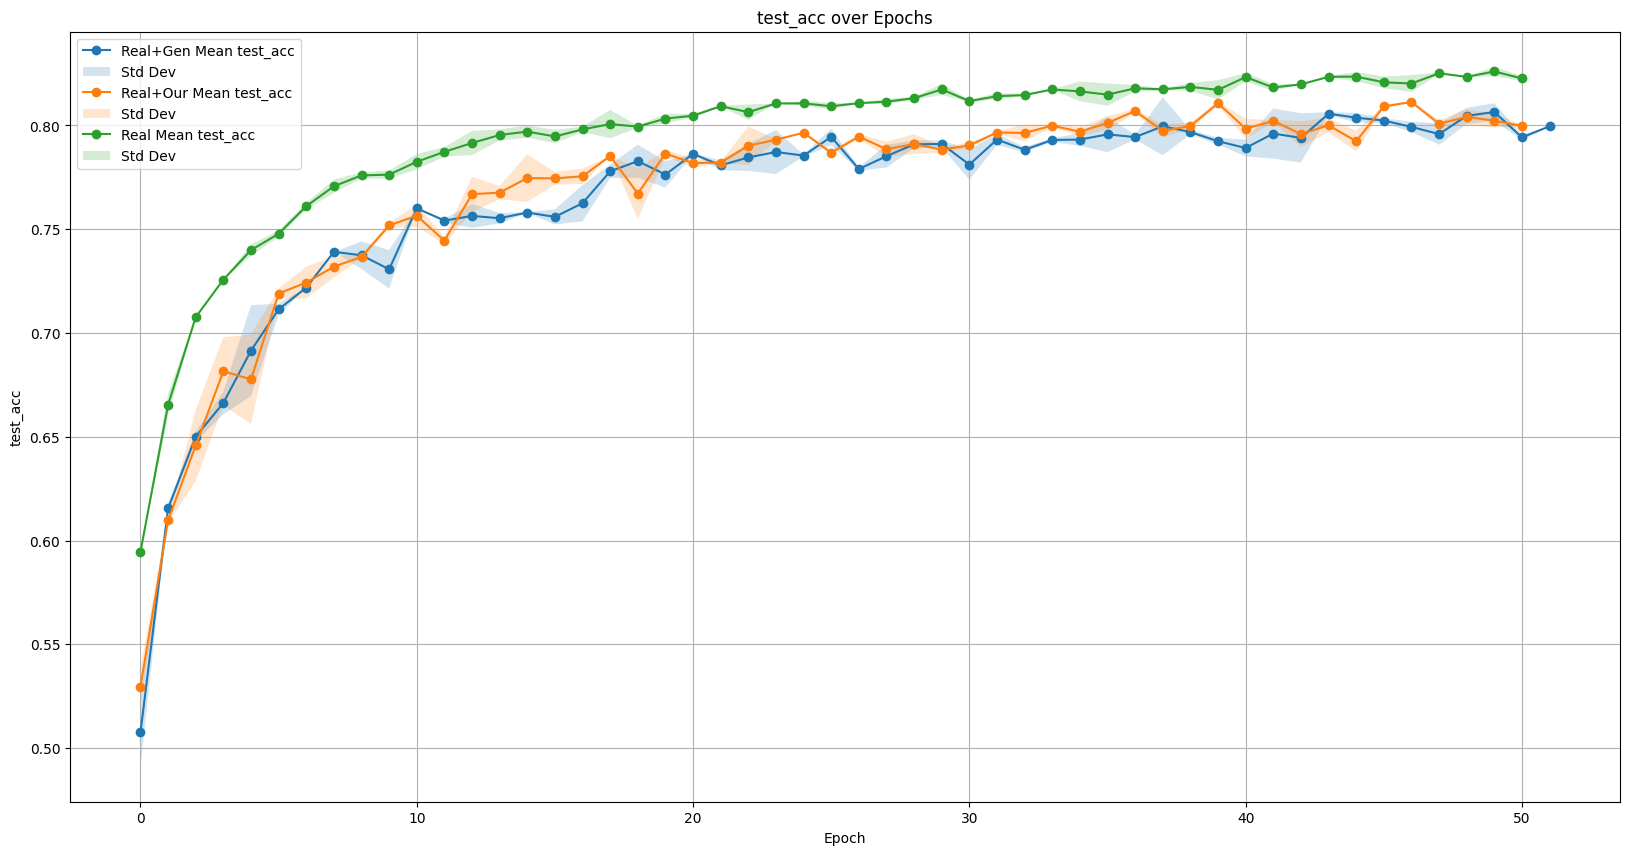

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
train_logger.plot_metric(logger, *logger.get_experiment_ids(), metric='test_acc', ax=ax)